# Training Model with Target 2

#### train val split

In [ ]:
x_train2,x_val2,y_train2,y_val2= train_test_split(x_train, target_2, stratify= target_2, test_size=0.10)

#### Label encoding

In [ ]:
le= LabelEncoder()
y_train_en_2= le.fit_transform(y_train2)

le= LabelEncoder()
y_val_en_2= le.fit_transform(y_val2)

#### Feature Selection

In [ ]:
from pandas.core.common import random_state
from sklearn.feature_selection import SelectKBest,chi2,mutual_info_classif

k_best=SelectKBest(mutual_info_classif, k=30).fit(train_data,y_train_en_2)

cols=k_best.get_support(indices=True)
print(train_data.iloc[:,cols].shape)
train_kbest2=train_data.iloc[:,cols]
val_kbest2=val_data.iloc[:,cols]

(15444, 30)


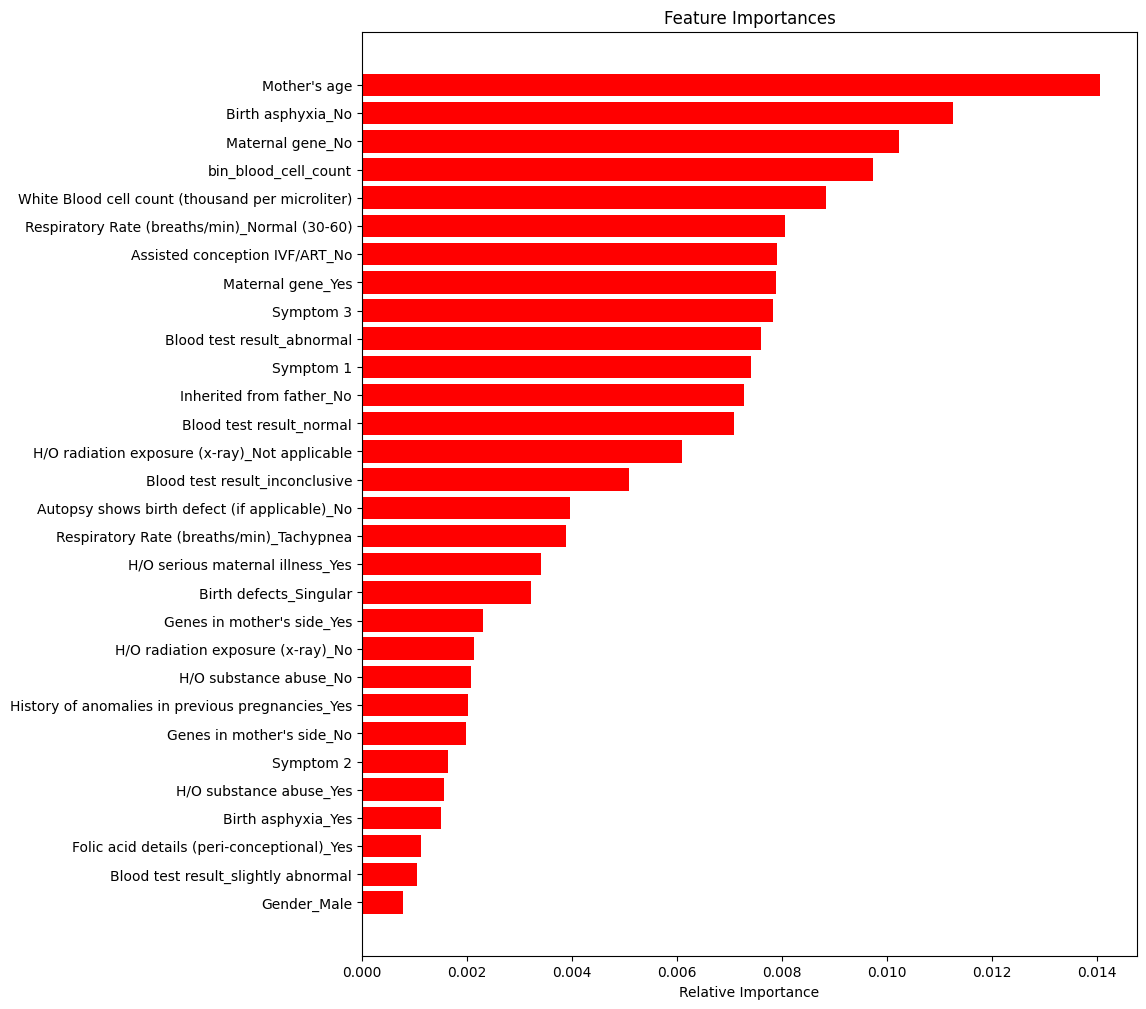

In [ ]:
features = train_data.columns
importances = k_best.scores_
indices = (np.argsort(importances))[-30:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

#### Upsampling data


In [ ]:
# with borderline smote we will upsample minority class
from imblearn.over_sampling import BorderlineSMOTE
sm = BorderlineSMOTE(random_state=42)
# it will return 2 variables
x_train_smote2, y_train_smote2 = sm.fit_resample(train_kbest2, pd.DataFrame(y_train_en_2))
print(f'''shape of X before SMOTE: {train_kbest2.shape}
shape of X after SMOTE: {x_train_smote2.shape}''')

# validation smote
sm = BorderlineSMOTE(random_state=42)
x_val_smote2, y_val_smote2 = sm.fit_resample(val_kbest2, pd.DataFrame(y_val_en_2))

shape of X before SMOTE: (15444, 30) 
shape of X after SMOTE: (35919, 30)


Text(0.5, 1.0, 'Disorder Subclass')

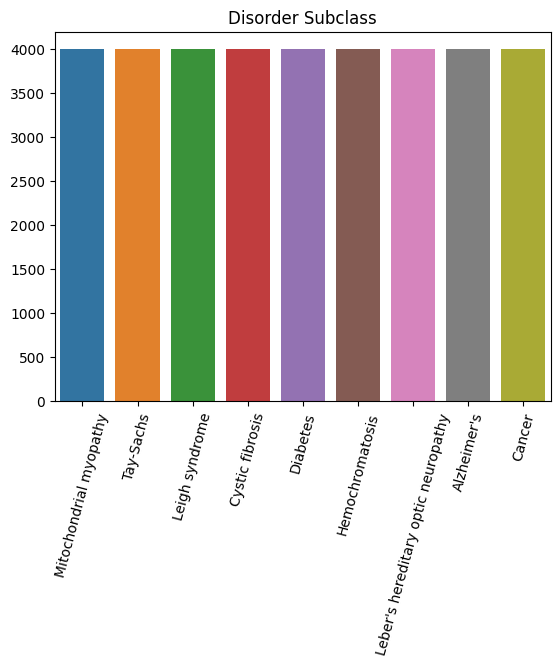

In [ ]:
fig, ax= plt.subplots()

values = y_train_smote2.value_counts()
sns.barplot(x= y_train2.unique(), y= values.values, ax = ax)
ax.set_xticklabels(rotation = 75, labels = y_train2.unique())
ax.set_title(y_train2.name)

#### Random Forest Classifier

In [ ]:
clf = RFC(random_state=42)
params = {
    'max_depth': [2, 3, 5, 8, 10, 12, 20],
    'min_samples_leaf': [5, 10, 20, 50, 80],
    'criterion': ["gini", "entropy"]
}
clf= RandomizedSearchCV(clf, params,verbose=10,n_jobs=-1)
clf.fit(x_train_smote2, y_train_smote2)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


RandomizedSearchCV(estimator=RandomForestClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [2, 3, 5, 8, 10, 12, 20],
                                        'min_samples_leaf': [5, 10, 20, 50,
                                                             80]},
                   verbose=10)

In [ ]:
print(clf.best_estimator_)

RandomForestClassifier(max_depth=20, min_samples_leaf=20, random_state=42)


In [ ]:
print(clf.best_score_)

0.5708685278932842


In [ ]:
clf = RFC(criterion='entropy',
          max_depth=20,
          min_samples_leaf=5,
          random_state=42)

clf.fit(x_train_smote2,y_train_smote2)

clf = CalibratedClassifierCV(clf, method="sigmoid")
clf.fit(x_train_smote2,y_train_smote2)

predict_y =clf.predict(x_train_smote2)
train_RFC_target2 = f1_score(y_train_smote2, predict_y, average='macro')
print ('The train f1_macro is:',f1_score(y_train_smote2, predict_y,average='macro'))

predict_y = clf.predict(x_val_smote2)
val_RFC_target2 = f1_score(y_val_smote2, predict_y, average='macro')
print('The cross validation f1_macro is:',f1_score(y_val_smote2, predict_y,average='macro'))

The train f1_macro is: 0.971480799538955
The cross validation f1_macro is: 0.13677357380693844


####Decision Tree classifier

In [ ]:
clf = DecisionTreeClassifier(random_state=42)
params = {
    'max_depth': [2, 3, 5, 8, 10, 12, 20],
    'min_samples_leaf': [5, 10, 20, 50, 80],
    'criterion': ["gini", "entropy"]
}
clf= GridSearchCV(clf, params, verbose=10, n_jobs=-1)
clf.fit(x_train_smote2, y_train_smote2)

Fitting 5 folds for each of 70 candidates, totalling 350 fits


GridSearchCV(estimator=DecisionTreeClassifier(random_state=42), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': [2, 3, 5, 8, 10, 12, 20],
                         'min_samples_leaf': [5, 10, 20, 50, 80]},
             verbose=10)

In [ ]:
print(clf.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=20, min_samples_leaf=5,
                       random_state=42)


In [ ]:
print(clf.best_score_)

0.4936953458534085


In [ ]:
clf = DecisionTreeClassifier(criterion='entropy', max_depth=20,
                            min_samples_leaf=5, random_state=42)
clf.fit(x_train_smote2,y_train_smote2)

clf = CalibratedClassifierCV(clf, method="sigmoid")
clf.fit(x_train_smote2,y_train_smote2)
predict_y =clf.predict(x_train_smote2)

train_DT_target2 = f1_score(y_train_smote2, predict_y, average='macro')
print ('The train f1_macro is:',f1_score(y_train_smote2, predict_y,average='macro'))

predict_y = clf.predict(x_val_smote2)
val_DT_target2 = f1_score(y_val_smote2, predict_y, average='macro')
print('The cross validation f1_macro is:',f1_score(y_val_smote2, predict_y,average='macro'))

The train f1_macro is: 0.852374058011345
The cross validation f1_macro is: 0.12303658482961555


####LGBM

In [ ]:
# to balance the data setting is_unbalance to true
clf = LGBM.LGBMClassifier(random_state=42)

# setting parameters
params = {'max_depth':[4, 5, 6, 8, 10, 12], # max_depth shallow because it was overfitting the model very badly
          'num_leaves': [40, 60, 80, 100, 120],
          'min_samples_leaf': [10, 15, 20, 25, 30, 40],
          'learning_rate': [0.02, 0.05, 0.1, 0.2],
          'n_estimators': [50, 100, 150, 200, 300]} # keeping learning_rate low to penalize it more and to avoid overfit

# we use GridSearchCv method
# we take CV=3 to to get better results
clf= RandomizedSearchCV(clf, params, cv=10, scoring= 'f1_macro', return_train_score=True, n_jobs = -1)
clf.fit(x_train_smote2, y_train_smote2)

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=25. Current value: min_data_in_leaf=25
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010632 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7648
[LightGBM] [Info] Number of data points in the train set: 35919, number of used features: 30
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.1

RandomizedSearchCV(cv=10, estimator=LGBMClassifier(random_state=42), n_jobs=-1,
                   param_distributions={'learning_rate': [0.02, 0.05, 0.1, 0.2],
                                        'max_depth': [4, 5, 6, 8, 10, 12],
                                        'min_samples_leaf': [10, 15, 20, 25, 30,
                                                             40],
                                        'n_estimators': [50, 100, 150, 200,
                                                         300],
                                        'num_leaves': [40, 60, 80, 100, 120]},
                   return_train_score=True, scoring='f1_macro')

In [ ]:
# printing best parameters
clf.best_params_

{'num_leaves': 100,
 'n_estimators': 200,
 'min_samples_leaf': 25,
 'max_depth': 10,
 'learning_rate': 0.05}

In [ ]:
# now we have got best hyperparameter from train and cross validation data
clf = LGBM.LGBMClassifier(learning_rate= 0.05,
                          max_depth= 12,
                          min_samples_leaf = 80,
                          num_leaves= 250,
                          random_state=42)
# we will again train our train data with best hyperparameter
clf.fit(x_train_smote2,y_train_smote2)
clf = CalibratedClassifierCV(clf, method="sigmoid")
clf.fit(x_train_smote2,y_train_smote2)

predict_y = clf.predict(x_train_smote2)
train_LGBM_target2 = f1_score(y_train_smote2, predict_y, average='macro')
print ('The train f1_macro is:', f1_score(y_train_smote2, predict_y, average='macro'))

predict_y = clf.predict(x_val_smote2)
val_LGBM_target2 = f1_score(y_val_smote2, predict_y, average='macro')
print('The cross validation f1_macro is:',f1_score(y_val_smote2, predict_y, average='macro'))

[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] min_data_in_leaf is set with min_child_samples=20, will be overridden by min_samples_leaf=80. Current value: min_data_in_leaf=80
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010067 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7648
[LightGBM] [Info] Number of data points in the train set: 35919, number of used features: 30
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.197225
[LightGBM] [Info] Start training from score -2.1

####AutoML

In [ ]:
clf = AutoML()
automl_settings = {
    "time_budget": 2400,  # in seconds
    "metric": 'macro_f1',
    "task": 'classification'
}

clf.fit(x_train_smote2, np.array(y_train_smote2).ravel(),
        **automl_settings)   # we will again train our train data with best hyperparameter

[flaml.automl.logger: 09-10 05:18:53] {1679} INFO - task = classification
[flaml.automl.logger: 09-10 05:18:53] {1690} INFO - Evaluation method: cv
[flaml.automl.logger: 09-10 05:18:53] {1788} INFO - Minimizing error metric: 1-macro_f1
[flaml.automl.logger: 09-10 05:18:53] {1900} INFO - List of ML learners in AutoML Run: ['lgbm', 'rf', 'xgboost', 'extra_tree', 'xgb_limitdepth', 'lrl1']
[flaml.automl.logger: 09-10 05:18:53] {2218} INFO - iteration 0, current learner lgbm
[flaml.automl.logger: 09-10 05:18:54] {2344} INFO - Estimated sufficient time budget=12024s. Estimated necessary time budget=277s.
[flaml.automl.logger: 09-10 05:18:54] {2391} INFO -  at 1.5s,	estimator lgbm's best error=0.7810,	best estimator lgbm's best error=0.7810
[flaml.automl.logger: 09-10 05:18:54] {2218} INFO - iteration 1, current learner lgbm
[flaml.automl.logger: 09-10 05:18:56] {2391} INFO -  at 3.3s,	estimator lgbm's best error=0.7762,	best estimator lgbm's best error=0.7762
[flaml.automl.logger: 09-10 05:1

INFO:flaml.tune.searcher.blendsearch:No low-cost partial config given to the search algorithm. For cost-frugal search, consider providing low-cost values for cost-related hps via 'low_cost_partial_config'. More info can be found at https://microsoft.github.io/FLAML/docs/FAQ#about-low_cost_partial_config-in-tune


[flaml.automl.logger: 09-10 05:35:53] {2391} INFO -  at 1020.4s,	estimator lrl1's best error=0.7587,	best estimator extra_tree's best error=0.2705
[flaml.automl.logger: 09-10 05:35:53] {2218} INFO - iteration 68, current learner lrl1
[flaml.automl.logger: 09-10 05:36:46] {2391} INFO -  at 1073.0s,	estimator lrl1's best error=0.7587,	best estimator extra_tree's best error=0.2705
[flaml.automl.logger: 09-10 05:36:46] {2218} INFO - iteration 69, current learner extra_tree
[flaml.automl.logger: 09-10 05:38:39] {2391} INFO -  at 1185.8s,	estimator extra_tree's best error=0.2654,	best estimator extra_tree's best error=0.2654
[flaml.automl.logger: 09-10 05:38:39] {2218} INFO - iteration 70, current learner lgbm
[flaml.automl.logger: 09-10 05:40:53] {2391} INFO -  at 1320.5s,	estimator lgbm's best error=0.4182,	best estimator extra_tree's best error=0.2654
[flaml.automl.logger: 09-10 05:40:53] {2218} INFO - iteration 71, current learner lrl1
[flaml.automl.logger: 09-10 05:41:46] {2391} INFO - 

In [ ]:
predict_y = clf.predict(x_train_smote2)
train_AutoML_target2 = f1_score(y_train_smote2, predict_y, average='macro')
print ('The train f1_macro is:', f1_score(y_train_smote2, predict_y,average='macro'))

predict_y = clf.predict(x_val_smote2)
val_AutoML_target2 = f1_score(y_val_smote2, predict_y, average='macro')
print('The cross validation f1_macro is:',f1_score(y_val_smote2, predict_y,average='macro'))

The train f1_macro is: 1.0
The cross validation f1_macro is: 0.11651816207053645
